In [ ]:
# sources :
# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
# https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

#### TO DO #####

#   Function for preprocessing the data:
#    OK incorporez fonction encodage avant de créer les composite features
#    OK laisser le OHE à part
#    OK mettre à jour les classifs de variables

#   Normality tests:
#    OK  skewness only for numerical variables (numeric continue)
#    OK. Log1 or Log10 ?? stick to log10
#    OK. What about composite features created : create them THEN apply Log transformation if skewed
#    OK. Review Log10 values (some are NaN ....) ==> Log10 will 'distort' data and give some NaN values, stick to Log1p

##  Feature selection :
#    OK.settle on the method for selecting correlated feats : Pearson (default in the .corr method)

#   Feature engineering :
#    1. add polynomial features...?
#    2. use clustering (kmeans) like in Linda's hands on workshop to create features
#    3. remove atypical sales (foreclosure...)

##  Model selection :
#    1. only linear regression models (check Kaggle for ideas on best model), 
#    2. tune models (epsilon for Huber Loss, grid search, etc...)
##   OK. create function to select related variables created with OHE

### TEST SET : test all the functions (pay attention to columns with different values than in train set...)
### TEST SET : can I drop outliers from the TEST set ?


##### TOPICS to discuss ####
# 1. Normal distribution:
#    a. how to assess normality ? skew / kurtosis / tests / visual
#.   b. how to achieve normality ? Log Tranform and other / to which type of variable to apply : numeric, categorical


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
from scipy import stats
from scipy.stats import norm, skew

In [2]:
# loading the data
data = pd.read_csv('house-prices.csv')
print('Dataset has {} entries and {} features.'.format(data.shape[0], data.shape[1]))

Dataset has 2430 entries and 82 features.


In [3]:
# Function for preprocessing the data
def preprocess_df(df):
    
    df_clean = df.copy()
    
    ###  Removing outliers : very large houses (more than 4000 square feet)
    df_clean = df_clean[df_clean['Gr Liv Area'] < 4000]
    
    ### Handling missing values
    # Features that are not necessary
    columns_to_drop = ['PID', 'Order']
    # Features that most likely does not exist if NaN
    columns_to_zero = ['Garage Area', 'Garage Cars', 'Total Bsmt SF', 'Bsmt Half Bath', 'Bsmt Full Bath', 
                      'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF']
    # Fill with NA
    columns_to_NA = ['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu', 'Garage Type',
                 'Garage Finish','Garage Qual','Garage Cond', 'Bsmt Qual' , 'Bsmt Cond' , 'Bsmt Exposure' ,
                 'BsmtFin Type 1' , 'BsmtFin Type 2']
    # ...
    columns_to_none = ['Mas Vnr Type']
    # 
    columns_to_mean = ['Mas Vnr Area', 'Lot Frontage']
    #...
    columns_to_mode = ['Electrical']
    
    df_clean = df_clean.drop(columns_to_drop, axis=1)
    df_clean[columns_to_zero] = df[columns_to_zero].fillna(0)
    df_clean[columns_to_NA] = df[columns_to_NA].fillna('NA')
    df_clean[columns_to_none] = df[columns_to_none].fillna('None')
    df_clean[columns_to_mean] = df[columns_to_mean].fillna(df[columns_to_mean].mean())
    df_clean[columns_to_mode] = df[columns_to_mode].fillna(df[columns_to_mode].mode().iloc[0,0]) 
    
    ### Feature engineering:
    
    ## Normalization
    # Add a LogSalePrice variable to the DataFrame:
    df_clean['LogSalePrice'] = np.log10(df_clean['SalePrice'])
    # other features with skewness +- 1
    # ...
    
    ## Total counts:
    # Total surface count
    df_clean['Total SF'] = df_clean['Total Bsmt SF'] + df_clean['Gr Liv Area']
    
    # Total room count
    df_clean['Total Rooms'] = (df_clean['TotRms AbvGrd'] + df_clean['Bsmt Full Bath'] + 
                                df_clean['Bsmt Half Bath'] + df_clean['Full Bath'] + df_clean['Half Bath'])
    
    ## Binary features:
    # Built before 1980 & no remodeling
    #df_clean['Built/Re bef 80'] = (df_clean['Year Remod/Add'] >1980)*1
    
    # Creating a 'Remodeled' feature (if YearRemodAdd != YearBuilt) 
    df_clean['Remodeled'] = (df_clean['Year Remod/Add'] != df_clean['Year Built']) * 1
    
    # Creating a 'RecentRemodel' feature if a remodeling happenned in the year the house was sold
    df_clean['RecentRemodel'] = (df_clean['Year Remod/Add'] == df_clean['Yr Sold']) * 1
    
    # Creating a 'NewHouse' featureWas this house sold in the year it was built?
    df_clean['NewHouse'] = (df_clean['Year Built'] == df_clean['Yr Sold']) * 1

    # Age of the house
    #adf_cl["Age"] = 2010 - df_clean["Year Built"]
       
    # Time since sold
    #df_clean["TimeSinceSold"] = 2010 - df_clean["Yr Sold"]
    
    # Sale seasonality feature (high & low season)
    df_clean['Sale Season'] = df_clean['Mo Sold'].replace({1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:1, 9:0, 10:0, 11:0, 12:0})
    
    ### ENCODING
    
    # Encoding Ordinal variables:
    # assigning a value from 0 (none) / 1 (poor) to 5 or 6 (excellent) to these variables
    quality_features = ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Heating QC', 'Kitchen Qual',
                    'Fireplace Qu', 'Garage Qual', 'Garage Cond', 'Pool QC']
    df_clean[quality_features] = df_clean[quality_features].replace({
        'Ex' : 5, 'Gd' : 4,'TA' : 3, 'Fa' : 2, 'Po' : 1, 'NA' : 0
    })
    
    # Encoding other ordinal variables, with specific 'scales', creating a dict for each variable,
    # and using .replace method
    other_ord_features = {
        'Lot Shape' : {'Reg': 4, 'IR1': 3, 'IR2' : 2, 'IR3' : 1},
        'Utilities' : {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1},
        'Land Slope' : {'Gtl' : 3, 'Mod' : 2, 'Sev' : 1},
        'Bsmt Exposure' : {'Gd' : 4, 'Av' : 3,'Mn' : 2, 'No' : 1, 'NA' : 0},
        'BsmtFin Type 1' : {'GLQ' : 6, 'ALQ' : 5,'BLQ' : 4, 'Rec' : 3, 'LwQ' : 2, 'Unf' : 1, 'NA' : 0},
        'BsmtFin Type 2' : {'GLQ' : 6, 'ALQ' : 5,'BLQ' : 4, 'Rec' : 3, 'LwQ' : 2, 'Unf' : 1, 'NA' : 0},
        'Electrical' : {'SBrkr' : 5, 'FuseA' : 4,'FuseF' : 3, 'FuseP' : 2, 'Mix' : 1},
        'Functional' : {'Typ' : 8, 'Min1' : 7,'Min2' : 6, 'Mod' : 5, 'Maj1' : 4, 'Maj2' : 3, 'Sev' : 2, 'Sal':1},
        'Garage Finish' : {'Fin' : 3, 'RFn' : 2,'Unf' : 1, 'NA' : 0},
        'Paved Drive' : {'Y' : 3, 'P' : 2,'N' : 1},
        'Fence' : {'GdPrv' : 4, 'MnPrv' : 3,'GdWo' : 2, 'MnWw' : 1, 'NA' : 0}
    }
    df_clean = df_clean.replace(other_ord_features)  
                               
    ### Feature engineering continued:
    
    ## Composite features :
    # Overall quality of the house
    df_clean['Overall Grade'] = df_clean['Overall Qual'] * df_clean['Overall Cond']

    # Overall quality of the garage
    df_clean['Garage Grade'] = df_clean['Garage Qual'] * df_clean['Garage Cond']
    
    # Overall quality of the exterior
    df_clean['Exter Grade'] = df_clean['Exter Qual'] * df_clean['Exter Cond']
    
    # Composite of two most correlated features to the Sale Price : TotalSF & Overall Quality
    df_clean['OverallQualxTotalSF'] = df_clean['Total SF'] * df_clean['Overall Qual']
    
                               
    ## Binning years columns
 
    #To DO : replicate to other years columns:
    #cols_to_bin = ['Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Yr Sold']    #keep Yr Sold ? 
    
    pd.options.mode.chained_assignment = None  # disabling warnings on chained assignment, I think this is the right 
                                                #choice as I am working on a copy anyway
    df_clean['Garage Yr Blt'].loc[df_clean['Garage Yr Blt'] <= 1960] = 1
    df_clean['Garage Yr Blt'].loc[(df_clean['Garage Yr Blt'] > 1960) & (df_clean['Garage Yr Blt'] <= 1978)] = 2
    df_clean['Garage Yr Blt'].loc[(df_clean['Garage Yr Blt'] > 1978) & (df_clean['Garage Yr Blt'] <= 2002)] = 3
    df_clean['Garage Yr Blt'].loc[df_clean['Garage Yr Blt'] > 2002] = 4
    #create a specific bin for misssing values
    df_clean['Garage Yr Blt'].loc[df_clean['Garage Yr Blt'].isnull()] = 0
    
    # Final check for missing values
    print('Dataset has {} entries and {} features.'.format(df_clean.shape[0], df_clean.shape[1]))
    print("There are",df_clean.isnull().sum().sum(),"missing values remaining.")
    
    return df_clean

In [4]:
df_clean = preprocess_df(data)

Dataset has 2426 entries and 91 features.
There are 0 missing values remaining.


In [5]:
# classify variables

# 1 - Numeric variables
numeric = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area','BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF',
          '1st Flr SF','2nd Flr SF','Low Qual Fin SF','Gr Liv Area','Garage Area','Wood Deck SF','Open Porch SF',
           'Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area','Misc Val', 'Total SF',  'OverallQualxTotalSF'
          ]
# 2 - Categorical variables
# 2.1 - Categorical variables, ordinal (possibility of ordering)
categorical_ordinal = ['Lot Shape', 'Utilities', 'Land Slope', 'Overall Qual', 'Overall Cond', 'Exter Qual',
                      'Exter Cond','Bsmt Qual', 'Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2',
                      'Heating QC','Electrical','Kitchen Qual','Functional','Fireplace Qu','Garage Finish','Garage Qual',
                       'Garage Cond','Paved Drive','Pool QC','Fence', 'Overall Grade', 'Garage Grade', 'Exter Grade'
                      ]
# 2.2 - Categorical variables, nominal (no possibility to order) 
categorical_nominal = ['MS SubClass','MS Zoning','Street', 'Alley', 'Land Contour', 'Lot Config', 'Neighborhood',
                      'Condition 1', 'Condition 2', 'Bldg Type','House Style','Roof Style', 'Roof Matl','Exterior 1st',
                      'Exterior 2nd','Mas Vnr Type','Foundation','Heating','Central Air','Garage Type','Misc Feature',
                       'Sale Type','Sale Condition', 'Remodeled', 'RecentRemodel', 'NewHouse', 'Sale Season'
                      ]
# 2.3 - Categorical variables, discrete
categorical_discrete = ['Year Built', 'Year Remod/Add','Bsmt Full Bath','Bsmt Half Bath','Full Bath','Half Bath',
                       'Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces','Garage Yr Blt','Garage Cars','Mo Sold',
                        'Yr Sold', 'Total Rooms'
                       ]
categorical = categorical_ordinal + categorical_nominal + categorical_discrete

In [6]:
#Normality tests
#check if distribution are normal (heavy tail ?) for continuous variables
# stick with kurtosis (high tail?) and skewness analysis
df_clean.skew().sort_values(ascending = False)

Misc Val               20.885676
Pool Area              18.015203
Pool QC                17.390010
Lot Area               13.140634
Low Qual Fin SF        12.456269
3Ssn Porch             11.903630
NewHouse                5.060548
Kitchen AbvGr           4.374352
Enclosed Porch          4.184678
BsmtFin SF 2            4.032680
Bsmt Half Bath          3.993066
Screen Porch            3.773936
RecentRemodel           3.195104
BsmtFin Type 2          3.092316
Open Porch SF           2.616856
Mas Vnr Area            2.510134
Wood Deck SF            1.918250
Fence                   1.706178
SalePrice               1.604094
MS SubClass             1.377146
Lot Frontage            1.356486
Exter Cond              1.342980
OverallQualxTotalSF     1.173100
Bsmt Exposure           1.091074
1st Flr SF              0.935724
Bsmt Unf SF             0.928898
Gr Liv Area             0.830759
2nd Flr SF              0.829521
BsmtFin SF 1            0.813868
Exter Grade             0.792116
Exter Qual

In [ ]:
for col in numeric:
    plt.figure(figsize=(3,3))
    sns.distplot(df_clean[col])
    #plt.hist(df_clean[col])
    plt.title(col)
    plt.show
    print(col, "Skewness: %f" % data[col].skew())
    print(col, "Kurtosis: %f" % data[col].kurt())

In [7]:
# Transform all the skewed feature by taking log ?
# skew > 0,75 , considered as moderately to highly skewed
# This will make the features more normal.

# To do after encoding but BEFORE OHE
# TO DO : compléter liste 'numeric' des features crées 
# Check the skewness of numerical features
numeric_features = pd.Index(numeric)

skewed_features = df_clean[numeric_features].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[abs(skewed_features) > 0.75]
print("\nSkewed numerical features to log transform: \n")
skewness = pd.DataFrame({'Skew' :skewed_features})
skewness.sort_values(by='Skew', ascending = False)


Skewed numerical features to log transform: 



,Skew
Misc Val,20.872760
Pool Area,18.004062
Lot Area,13.132508
Low Qual Fin SF,12.448565
3Ssn Porch,11.896268
Enclosed Porch,4.182091
BsmtFin SF 2,4.030186
Screen Porch,3.771602
Open Porch SF,2.615238
Mas Vnr Area,2.508582


In [8]:
## TO do : log 1 or log10 ??

# Log transform of the skewed numerical features 
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
#skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.75]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
df_clean[skewed_features] = np.log1p(df_clean[skewed_features])

18 skewed numerical features to log transform


In [9]:
# compare before and after log transform
df_clean[skewed_features].skew()

Lot Frontage           -1.070485
Lot Area               -0.448306
Mas Vnr Area            0.487983
BsmtFin SF 1           -0.616978
BsmtFin SF 2            2.430884
Bsmt Unf SF            -2.106542
1st Flr SF             -0.023496
2nd Flr SF              0.334585
Low Qual Fin SF         9.017904
Gr Liv Area            -0.099839
Wood Deck SF            0.169100
Open Porch SF          -0.043779
Enclosed Porch          1.986274
3Ssn Porch              9.123319
Screen Porch            2.900091
Pool Area              15.630145
Misc Val                5.153962
OverallQualxTotalSF    -0.730520
dtype: float64

In [ ]:
# Scale the data ? see in EPFL course
# Additional processing: scale the data.   
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_df_munged[numeric_features])

scaled = scaler.transform(train_df_munged[numeric_features])
for i, col in enumerate(numeric_features):
    train_df_munged[col] = scaled[:, i]

scaled = scaler.transform(test_df_munged[numeric_features])
for i, col in enumerate(numeric_features):
    test_df_munged[col] = scaled[:, i]

### 1.3 Outliers

In [ ]:
# Find outliers:
# plot of SALE PRICE versus GR LIV AREA 
plt.Figure(figsize=(8,8))
plt.scatter(data['SalePrice'], data['Gr Liv Area'] );

In [ ]:
#Remove very large houses (more than 4000 square feet) (this is included in the preprocessing function)
#df_clean = df_clean[df_clean['Gr Liv Area'] < 4000]

In [ ]:
#impact of removing theses 4 outliers
a = df_clean['Gr Liv Area'].describe() - data['Gr Liv Area'].describe()
print(a)
plt.Figure(figsize=(8,8))
plt.scatter(df_clean['SalePrice'], df_clean['Gr Liv Area']  );
plt.show()

## 2. Encoding

In [10]:
# Function to encode df

def encode(df):
    df_encoded = df.copy()
    
    # One-hot encoding for nominal variables 
    df_encoded = pd.get_dummies(df_encoded, columns=categorical_nominal)
    
    print('Origina Size:', df.shape, 'Size when encoded:', df_encoded.shape)
    return df_encoded

In [11]:
df_encoded = encode(df_clean)

Origina Size: (2426, 91) Size when encoded: (2426, 258)


In [ ]:
##### TO CHECK : #### Test vs train sets ####

# These onehot columns are missing in the test data, so drop them from the
# training data or we might overfit on them.
drop_cols = [
                "_Exterior1st_ImStucc", "_Exterior1st_Stone",
                "_Exterior2nd_Other","_HouseStyle_2.5Fin", 
            
                "_RoofMatl_Membran", "_RoofMatl_Metal", "_RoofMatl_Roll",
                "_Condition2_RRAe", "_Condition2_RRAn", "_Condition2_RRNn",
                "_Heating_Floor", "_Heating_OthW",

                "_Electrical_Mix", 
                "_MiscFeature_TenC",
                "_GarageQual_Ex", "_PoolQC_Fa"
            ]
            ]
#train_df.drop(drop_cols, axis=1, inplace=True)


# This column is missing in the training data. There is only one example with
# this value in the test set. So just drop it.
test_df.drop(["_MSSubClass_150"], axis=1, inplace=True)

# Drop these columns. They are either not very helpful or they cause overfitting.
drop_cols = [
    "_Condition2_PosN",    # only two are not zero
    "_MSZoning_C (all)",
    "_MSSubClass_160",
]
train_df.drop(drop_cols, axis=1, inplace=True)
test_df.drop(drop_cols, axis=1, inplace=True)


In [ ]:
# Regarding Label Encoder:
# after Fred 1-on-1 : 
# déconseille d'utiliser Laberl encoder,
# ratio datapoints vs. nombre colonnes : 10%
# va créer une 'relation' ! (qui n'existe pas)

##### Here is my problem: #####

#2. Label Encoding categorical nominal variables with sklearn LabelEncoder 
#Labeling with scikit learn (instead of OHE) the categorical_nominal features in order to reduce dimensionality
#for cat ORDINAL, the order is not the same, so I stick to the .replace method

# import preprocessing from sklearn
from sklearn import preprocessing
# Create a LabelEncoder object and fit it to each feature in test DF
le = preprocessing.LabelEncoder()
# use df.apply() to apply le.fit_transform to categorical_nominal features

df_le = df_clean.copy()
#df_le[categorical_ordinal].apply(le.fit_transform) #not working ?

#df_le = df_clean[categorical_nominal].apply(le.fit_transform) # works but has only the transformed columns

print('Origina Size:', df_clean.shape)
print('Size when Label encoded:', df_le.shape)

#I don't understand why the following works, ie. returne the labeled columns
df_le[categorical_ordinal].apply(le.fit_transform).head()

# but this doesn't return the labeled columns ?
df_le[categorical_ordinal] = df_le[categorical_ordinal].apply(le.fit_transform)
df_le[categorical_nominal].head()

#and this doesn't work neither : 
df_le.apply(le.fit_transform(df_clean[categorical_nominal]))

# It works with a sklearn pipeline, although it's not my code & I did not yet looked further into pipelines
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

# I want to encode only the categorical_nominal features, while leaving the other features untransformed.
#df_le = MultiColumnLabelEncoder(columns = categorical_nominal).fit_transform(df_clean)
#df_le.shape

## 3. Feature engineering


In [ ]:
# Let's have a closer look at the target variable: before removing outliers, skewed distribution
sns.distplot(data['SalePrice']);
print("Skewness: %f" % data['SalePrice'].skew())
print("Kurtosis: %f" % data['SalePrice'].kurt())

In [ ]:
#After removing outliers, reduces skewness a bit
sns.distplot(df_clean['SalePrice']);
print("Skewness: %f" % df_clean['SalePrice'].skew())
print("Kurtosis: %f" % df_clean['SalePrice'].kurt())

In [ ]:
# Add a LogSalePrice variable to the DataFrame (this is included in the preprocessing function)
#df_clean['LogSalePrice'] = np.log10(df_clean['SalePrice'])

In [ ]:
# plot of the log10 of SalePrice :, skewness reduced
sns.distplot(df_clean['LogSalePrice']);
print("Skewness: %f" % df_clean['LogSalePrice'].skew())
print("Kurtosis: %f" % df_clean['LogSalePrice'].kurt())

In [ ]:
# Total surface count
#df_clean['TotalSF'] = df_clean['Total Bsmt SF'] + df_clean['Gr Liv Area']
print(df_clean['Total SF'].describe())

In [ ]:
# Total count of rooms
#df_clean['Total_rooms'] = (df_clean['TotRms AbvGrd'] + df_clean[''Bsmt Full Bath'] + 
#                                df_clean['Bsmt Half Bath'] + df_clean['Full Bath'] + df_clean['Half Bath']) 

total_rooms = ['TotRms AbvGrd', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath']
print(df_clean[total_rooms].describe())

In [ ]:
# indicator variables (year of construction is older than some threshold)
# Built before 1980 & no remodeling 
# df_clean['Built/Re bef 80'] = (df_clean['Year Remod/Add'] >1980)*1

sns.distplot(df_clean['Year Remod/Add']);
print(df_clean['Year Remod/Add'].describe())

# or just add a 'Remodeled' feature :
# If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
# df_clean["Remodeled"] = (df_clean["Year Remod/Add"] != df_clean["Year Built"]) * 1

In [ ]:
# create a seasonality feature

#visual rerpresentation of sales per given month
grp = df_clean.groupby(['Yr Sold','Mo Sold'])
piv = grp.count()['SalePrice'].reset_index()
piv.columns = ['Overall Qual','Mo Sold','SalePrice']
sns.pointplot(x='Mo Sold', y='SalePrice', hue='Overall Qual', data=piv, join=True)
plt.legend(loc='best', bbox_to_anchor=(1.05, 0.8, 0.2, 0));

#create a feature with a 'high season' and 'low season'
#df_clean['SaleSeason'] = df_clean['Mo Sold'].replace({1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:1, 9:0, 10:0, 11:0, 12:0})

In [ ]:
# Creation of a composite feature : TotalSF * Overall Quality:
# df_clean['OverallQualxTotalSF'] = df_clean['TotalSF'] * df_clean['Overall Qual']

In [ ]:
#add polynomial features...?
# to which variable ? to the most correlated one ? we are looking to add linearity...

## USE polynomial func (see EPFL course)
# 3* Polynomials on the top 10 existing features
train["OverallQual-s2"] = train["OverallQual"] ** 2
train["OverallQual-s3"] = train["OverallQual"] ** 3
train["OverallQual-Sq"] = np.sqrt(train["OverallQual"])

In [ ]:
# remove atypical sales (foreclosure...)
df_encoded['Sale Condition_Abnorml'].value_counts()

## 4. Feature selection

In [ ]:
# 3 models, with few to all features
# choose the features : 
# scatter plot against sales price to prove the point
# !! the use of scatter plots instead of boxplots, which are more suitable for categorical variables visualization.

# collinear variables: what to do with highly collinear variables ?

# 1) without any in depth analysis, I would say that the most important features are =
# OverallQual (which is a variable that I don't like because I don't know how it was computed; a funny exercise would be to predict 'OverallQual' using all the other variables available).
# YearBuilt.
# TotalBsmtSF.
# GrLivArea.

### 4.1 Univariate feature selection
Univariate feature selection examines each feature individually to determine the strength of the relationship of the feature with the response variable.



### 4.1.1 Pearson correlation coef
One of the simplest method for understanding a feature’s relation to the response variable is Pearson correlation coefficient, which measures linear correlation between two variables. The resulting value lies in [-1;1]

__Works good when linear relation between feature and target__

There are at least two reasons why to prefer Pearson correlation over more sophisticated methods such as MIC or distance correlation when the relationship is close to linear. For one, computing the Pearson correlation is much faster, which may be important in case of big datasets. Secondly, the range of the correlation coefficient is [-1;1] (instead of [0;1] for MIC and distance correlation). This can relay useful extra information on whether the relationship is negative or positive, i.e. do higher feature values imply higher values of the response variables or vice versa. But of course the question of negative versus positive correlation is only well-posed if the relationship between the two variables is monotonic


In [ ]:
# FRED:

# p value : corrélation due au hasard ?
# p value < 5% 
# cf. intro to stat learning
#éventuellement utiliser sklearn feature selection http://scikit-learn.org/stable/modules/feature_selection.html
#pearson correl : soit très corrélée soit -1
#approche quant (ce cours) vs. qual

In [12]:
# for the second model, take the most correlated features in abs value (is this pearson correl ?)
corr = df_clean.corr()
corr_abs = corr['SalePrice'].abs().sort_values(ascending=False)
print(corr_abs)

SalePrice              1.000000
LogSalePrice           0.947439
OverallQualxTotalSF    0.828420
Total SF               0.821375
Overall Qual           0.805112
Exter Qual             0.706781
Gr Liv Area            0.691521
Kitchen Qual           0.674688
Total Bsmt SF          0.664309
Garage Cars            0.648363
Garage Area            0.639412
Total Rooms            0.620936
1st Flr SF             0.614858
Bsmt Qual              0.607464
Garage Yr Blt          0.585149
Exter Grade            0.577145
Year Built             0.567879
Overall Grade          0.561023
Garage Finish          0.553746
Fireplace Qu           0.553327
Year Remod/Add         0.536960
Full Bath              0.534234
Fireplaces             0.492890
TotRms AbvGrd          0.486225
Mas Vnr Area           0.460767
Heating QC             0.452533
Open Porch SF          0.434783
Bsmt Exposure          0.416925
Lot Area               0.360621
BsmtFin Type 1         0.348346
RecentRemodel          0.338120
Wood Dec

In [ ]:
#this is correl after OHE
corr = df_encoded.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

__better method :__ 
 Scipy‘s pearsonr method computes both the correlation and p-value for the correlation, roughly showing the probability of an uncorrelated system creating a correlation value of this magnitude.

In [ ]:
# same corr matrix but presented graphically:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
# we detect highly collinear variables in the heatmap (light squares) :
# Total Bsmt SF & 1st Floor SF
# Garage features

In [ ]:
# most correlated features
corrmat = df_clean.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(df_clean[top_corr_features].corr(),annot=True)

In [ ]:
# error on this graph ??
# heatmap zoomed on Sale Price
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
# focus on year built : onlys slightly correlated
#'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'. 
# garage : only pick one
# 'TotalBsmtSF' and '1stFloor': only pick one
#'TotRmsAbvGrd' and 'GrLivArea', only pick one

In [ ]:
cols = ['SalePrice', 'Garage Cars', 'Garage Area']
corr = data[cols].corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

In [ ]:
cols = ['Garage Cars', 'Garage Area']
corr = data[cols].corr()
corr.sort_values(['Garage Cars'], ascending = False, inplace = True)
print(corr['Garage Cars'])

#### now, plot the data
__relying only on the correlation value on interpreting the relationship of two variables can be highly misleading, so it is always worth plotting the data__

In [ ]:
#scatter plot grlivarea/saleprice
var = 'Gr Liv Area'
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [ ]:
#scatter plot totalbsmtsf/saleprice
var = 'Total Bsmt SF'
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [ ]:
# relationship with categorical features
#box plot overallqual/saleprice
var = 'Overall Qual'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

In [ ]:
var = 'Year Built'
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

#### Feature selection : conclusion
GrLivArea' and 'TotalBsmtSF' seem to be linearly related with 'SalePrice'. Both relationships are positive, which means that as one variable increases, the other also increases. In the case of 'TotalBsmtSF', we can see that the slope of the linear relationship is particularly high.
'OverallQual' and 'YearBuilt' also seem to be related with 'SalePrice'. The relationship seems to be stronger in the case of 'OverallQual', where the box plot shows how sales prices increase with the overall quality.

### 5. Model selection

You can then create and evaluate different models. Split the data into train and test sets (50-50 split). Fit your model using the train set and evaluate it using the test one. Your analysis should include the following models.

A "simple" model with two variables (three with the target variable)
An "intermediate" model (between 10 and 20 variables).
A "complex model" with all variables.
Count the number of variables before applying one-hot encoding. Also, these variables can be combinations of other variables. For instance, the author of the data set suggests fitting a model using the total surface and the sale condition. This model has a total of two variables even if the total surface is itself a combination of two variables (basement + above grade surfaces) and encoding the sale condition variable with one-hot encoding leads to the creation of 6 dummy variables.

Try adding regularization (i.e., Ridge regression) for the intermediate and complex models. Tune the regularization strength using grid search.

Important: Remember to use the logarithm of the sale prices to fit your models.



In [ ]:
## only linear regression models ??
# lr, huber loss, SGD, RIDGE Regression ?

In [13]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
train_df, test_df = train_test_split(df_encoded, train_size=0.5, test_size=0.5, random_state=0)

print('Train DataFrame:', train_df.shape)
print('Test DataFrame:', test_df.shape)

Train DataFrame: (1213, 258)
Test DataFrame: (1213, 258)


In [14]:
# Function to create variables
# TO check if working every time
#maybe a problem with the tuple returned and its decomposition

def create_variables(features, target):
    X_tr, y_tr, X_te, y_te = None, None, None, None  # is it worth doing this ? Variables inside a function are 'new'??
    X_tr = train_df[features].values
    y_tr = train_df[target].values
    X_te = test_df[features].values 
    y_te = test_df[target].values
    print('X_tr shape:', X_tr.shape, 'y_tr shape:', y_tr.shape,'X_te shape:', X_te.shape, 'y_te shape:', y_te.shape)
    return X_tr, y_tr, X_te, y_te

In [15]:
# Define error metric : 
# Root mean squared error
def RMSE(y, y_pred):
    mse = np.mean(np.square(y - y_pred)) 
    return np.sqrt(mse) 

# Mean absolute error
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))    

In [16]:
from sklearn.linear_model import LinearRegression, HuberRegressor

# Function to fit a linear regression
def fit_lr(X_train, y_train, X_test):
    # Create a linear regression
    lr = LinearRegression()
    
    # Fit it to train data
    lr.fit(X_train, y_train)
    
    # Compute predictions for test set
    y_pred = lr.predict(X_test)
    #print("Linear regression coefficients:",lr.coef_)
    return y_pred

# Function to fit Huber loss
def fit_hl(X_train, y_train, X_test):
    huber = HuberRegressor(epsilon=1.45)
    huber.fit(X_train, y_train) # Fit to train data
    y_pred = huber.predict(X_test) #compute predictions for test set
    return y_pred

#### "Simple" model with two variables (three with the target variable)


In [17]:
features = ['Overall Qual', 'Gr Liv Area']

# Create X/y variables

#using the function create_variables:
X_tr, y_tr, X_te, y_te = create_variables(features, 'LogSalePrice')

#X_tr = train_df[features].values
#y_tr = train_df.LogSalePrice.values
#X_te = test_df[features].values 
#y_te = test_df.LogSalePrice.values

#print('X_tr shape:', X_tr.shape, 'y_tr shape:', y_tr.shape,'X_te shape:', X_te.shape, 'y_te shape:', y_te.shape)

X_tr shape: (1213, 2) y_tr shape: (1213,) X_te shape: (1213, 2) y_te shape: (1213,)


In [18]:
# Median baseline
rmse_baseline = RMSE(y_te, np.median(y_te))
mae_baseline = MAE(10**y_te, np.median(10**y_te))

print('RMSE baseline: {:.3f}'.format(rmse_baseline))
print('MAE baseline: {:.3f}'.format(mae_baseline))

RMSE baseline: 0.178
MAE baseline: 54125.121


In [19]:
# Linear regression
y_pred = fit_lr(X_tr, y_tr, X_te)
rmse_lr = RMSE(y_te, y_pred)
mae_lr = MAE(10**y_te, 10**y_pred)

print('RMSE linear regression: {:.3f}'.format(rmse_lr))
print('MAE linear regression: {:.3f}'.format(mae_lr))

RMSE linear regression: 0.089
MAE linear regression: 24699.855


#### "Simple" model with two variables (three with the target variable) - 2

In [27]:
features = ['OverallQualxTotalSF', 'Exter Grade']

# Create X/y variables
X_tr, y_tr, X_te, y_te = create_variables(features, 'LogSalePrice')

# Median baseline
rmse_baseline = RMSE(y_te, np.median(y_te))
mae_baseline = MAE(10**y_te, np.median(10**y_te))

print('RMSE baseline: {:.3f}'.format(rmse_baseline))
print('MAE baseline: {:.3f}'.format(mae_baseline))

# Linear regression
y_pred = fit_lr(X_tr, y_tr, X_te)
rmse_lr = RMSE(y_te, y_pred)
mae_lr = MAE(10**y_te, 10**y_pred)

print('RMSE linear regression: {:.3f}'.format(rmse_lr))
print('MAE linear regression: {:.3f}'.format(mae_lr))

X_tr shape: (1213, 2) y_tr shape: (1213,) X_te shape: (1213, 2) y_te shape: (1213,)
RMSE baseline: 0.178
MAE baseline: 54125.121
RMSE linear regression: 0.082
MAE linear regression: 21975.992


#### "Simple" model with two variables (three with the target variable) - 3

In [53]:
features = ['OverallQualxTotalSF'] + df_encoded.filter(like='Sale Cond').columns.tolist()

# Create X/y variables
X_tr, y_tr, X_te, y_te = create_variables(features, 'LogSalePrice')

# Median baseline
rmse_baseline = RMSE(y_te, np.median(y_te))
mae_baseline = MAE(10**y_te, np.median(10**y_te))

print('RMSE baseline: {:.3f}'.format(rmse_baseline))
print('MAE baseline: {:.3f}'.format(mae_baseline))

# Linear regression
y_pred = fit_lr(X_tr, y_tr, X_te)
rmse_lr = RMSE(y_te, y_pred)
mae_lr = MAE(10**y_te, 10**y_pred)

print('RMSE linear regression: {:.3f}'.format(rmse_lr))
print('MAE linear regression: {:.3f}'.format(mae_lr))

X_tr shape: (1213, 7) y_tr shape: (1213,) X_te shape: (1213, 7) y_te shape: (1213,)
RMSE baseline: 0.178
MAE baseline: 54125.121
RMSE linear regression: 0.082
MAE linear regression: 22568.462


#### Intermediate model

In [89]:
features = (['OverallQualxTotalSF', 'Exter Qual', 'Total SF', 'Overall Qual', 'Gr Liv Area'] +
            df_encoded.filter(like='Garage').columns.tolist() +
            df_encoded.filter(like='Neighborhood').columns.tolist()+
           df_encoded.filter(like='Remodeled').columns.tolist()+
           df_encoded.filter(like='RecentRemodel').columns.tolist()+
           df_encoded.filter(like='NewHouse').columns.tolist()+
           df_encoded.filter(like='Sale Season').columns.tolist()
           )
print(features)

# Create X/y variables
X_tr, y_tr, X_te, y_te = create_variables(features, 'LogSalePrice')

# Median baseline
rmse_baseline = RMSE(y_te, np.median(y_te))
mae_baseline = MAE(10**y_te, np.median(10**y_te))

print('RMSE baseline: {:.3f}'.format(rmse_baseline))
print('MAE baseline: {:.3f}'.format(mae_baseline))

# Linear regression
y_pred = fit_lr(X_tr, y_tr, X_te)
rmse_lr = RMSE(y_te, y_pred)
mae_lr = MAE(10**y_te, 10**y_pred)

# Huber Loss
y_pred_hl = fit_hl(X_tr, y_tr, X_te)
rmse_hl = RMSE(y_te, y_pred_hl)
mae_hl = MAE(10**y_te, 10**y_pred_hl)

print('RMSE linear regression: {:.3f}'.format(rmse_lr))
print('RMSE Huber Loss: {:.3f}'.format(rmse_hl))
print('MAE linear regression: {:.3f}'.format(mae_lr))
print('MAE Huber Loss: {:.3f}'.format(mae_hl))

['OverallQualxTotalSF', 'Exter Qual', 'Total SF', 'Overall Qual', 'Gr Liv Area', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Garage Grade', 'Garage Type_2Types', 'Garage Type_Attchd', 'Garage Type_Basment', 'Garage Type_BuiltIn', 'Garage Type_CarPort', 'Garage Type_Detchd', 'Garage Type_NA', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens', 'Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veen

#### Model with all the features

In [87]:
# Fitting a model with all the features
columns_to_exclude = ['SalePrice','LogSalePrice']
features = df_encoded.drop(columns_to_exclude, axis = 1).columns

# Create variables
X_tr, y_tr, X_te, y_te = create_variables(features, 'LogSalePrice')

# Linear regression
y_pred = fit_lr(X_tr, y_tr, X_te)
rmse_lr = RMSE(y_te, y_pred)
mae_lr = MAE(10**y_te, 10**y_pred)

# Huber Loss
y_pred_hl = fit_hl(X_tr, y_tr, X_te)
rmse_hl = RMSE(y_te, y_pred_hl)
mae_hl = MAE(10**y_te, 10**y_pred_hl)

print('RMSE linear regression: {:.3f}'.format(rmse_lr))
print('RMSE Huber Loss: {:.3f}'.format(rmse_hl))
print('MAE linear regression: {:.3f}'.format(mae_lr))
print('MAE Huber Loss: {:.3f}'.format(mae_hl))

X_tr shape: (1213, 256) y_tr shape: (1213,) X_te shape: (1213, 256) y_te shape: (1213,)
RMSE linear regression: 0.058
RMSE Huber Loss: 0.255
MAE linear regression: 13640.402
MAE Huber Loss: 81445.987


In [ ]:
#ill conditionoing : utiliser ridge regression
#checker collinear features
# colonnes identiques ? ou colonnes avec données qui changent pas ou peu (variable avec peu d'info à supprimer)
#puis voir notebook "encoding cat var" pour OHE sur validation set : fonction reindex de pandas

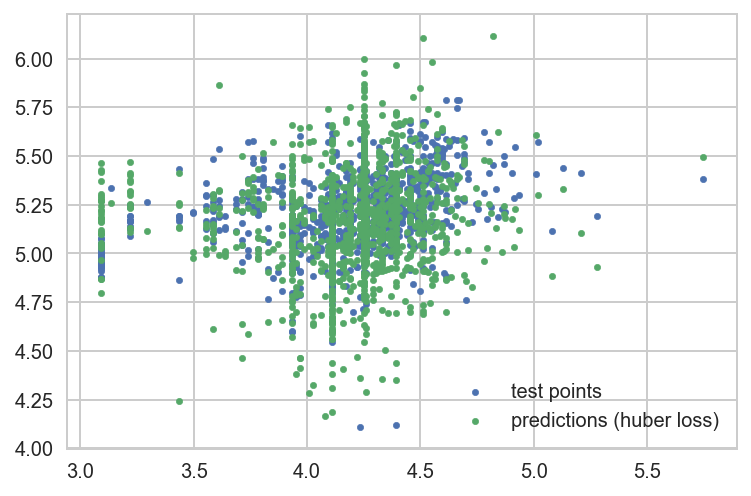

In [88]:
# Plot models
sale_price = X_te[:, 0] 
plt.scatter(sale_price, y_te, s=10, label='test points')
plt.scatter(sale_price, y_pred_hl, s=10, label='predictions (huber loss)')
plt.legend()
plt.show()

### Understanding the error metric

FRED:
You can get the MAE scores in dollars by raising your predictions to power 10: MAE(10**y_te, 10**y_pred) where y_te and y_pred are in "log10-dollars". In this project, the MAE metric is very important to get a more intuitive score to report - an MAE of 50,000 means that your predictions are on average 50 thousand dollars away from the observed price. Thanks for asking.

In [ ]:
# Final comparison
mae_values = [mae_baseline, mae_lr, mae_lr2, mae_wdnwd]
titles = ['median', 'lr', 'lr new features', 'two models']

xcor = np.arange(len(mae_values))
plt.bar(xcor, mae_values)
plt.xticks(xcor, titles)

plt.ylabel('MAE')
plt.show()